# Opening the black box

The inner working of deep neural network is notoriously difficult to interpret. It's fairly common to have networks with billions of internal parameters, and assign a human-understandable meaning to each of those is an impossible task. Clearly, we need some mediation between the fine details and the broad picture.

These kind of efforts fall under the umbrella term of explainable neural network (sometimes called interpretable networks). There's a plethora of techniques, broadly split in two: approaches to directly look into (and make sense) of the internal workings of the network; or trying to understand what the network is doing with the input data in human, plain terms.

For this notebook we'll focus on the latter case. We will implement Grad-CAM (Gradient-weighted Class Activation Mapping), a technique used to visualize where a convolutional neural network (CNN) is "looking" when it makes a prediction on an image. It creates a heatmap that highlights the regions of the image that were most important for the decision.

The technique was introduced with the paper "Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization"([Selvaraju et al., 2019](https://link.springer.com/article/10.1007/S11263-019-01228-7))

The steps are:

* get an image to process
* get a (already trained) CNN network
* do the actual Grad-CAM algorithm:
  * pass the image through the CNN to get the predicted class
  * backpropagate the gradient of that class score with respect to the feature maps of a chosen convolutional layer (usually the lasy one)
  * compute the average of these gradients over the width and height dimensions—this gives a weight for each channel
  * multiply each feature map by its weight, sum them up, and apply a ReLU
* overlay the resulting heatmap on the original image. This will highlight what parts of the image contributed more to the classification

We decided to directly implement Grad-CAM in the notebook instead of relying on external libraries for future compatibility, but you can skip the implementation details and just use it.

# 0) Setup

In [1]:
!pip install opencv-python

# 1) Get an image to investigate

We are going to use a picture of a magpie, directly taken from [its wikipedia page](https://en.wikipedia.org/wiki/Magpie). The image is by Pierre Selim released under CC BY-SA 2.0
https://creativecommons.org/licenses/by-sa/2.0, via Wikimedia Commons

We have stored a copy of the image within the github repo hosting this very notebook to ensure URL permanence.


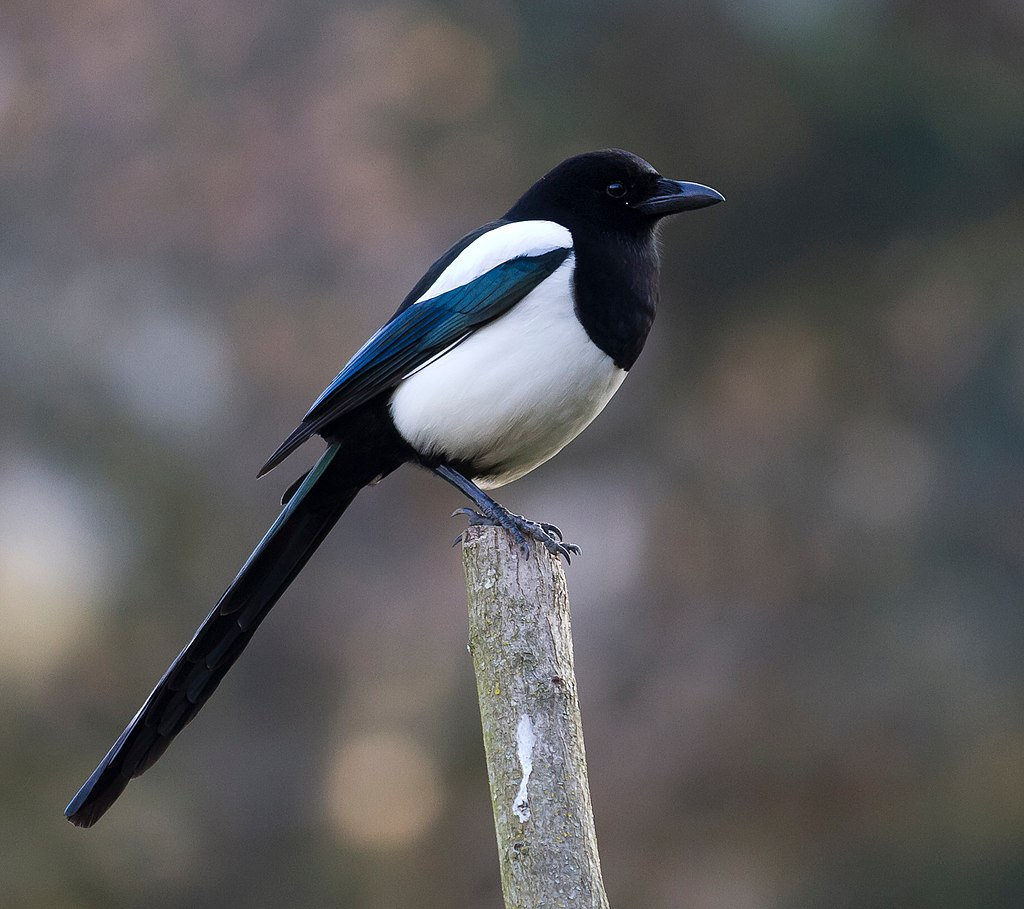

In [2]:
import urllib.request
from IPython.display import Image

#let's download the image, we save it locally
url = "https://raw.githubusercontent.com/ne1s0n/bioinformateachers/refs/heads/main/dlb/inside_the_network/magpie.jpg"
urllib.request.urlretrieve(url, "myimage.png")

#this is the absolute path of the local image, if the notebook is run under google colab
IMAGE_PATH = "/content/myimage.png"

#showing the image, just to check
Image(filename=IMAGE_PATH, width=500)

# 2) Getting a (trained) model

Grad-CAM is a technique useful to investigate a trained model, how it works and how it reasons. For this notebook we'll just take [the VGG16 model](https://keras.io/api/applications/vgg/) already present in Keras applications. The model has been trained to classify the 1000 classes of the IMAGENET database.

In [3]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

#let's take a look
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

The last convolution layer before the dense part of the network is called "block5_conv3". Grad-CAM targets this very layer, so let's keep that name in mind.

# 3) Pass the image through the network

We need to lod the image into a format palatable to VGG16 and run it through the network.

In [4]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

#load and preprocess the image
img = image.load_img(IMAGE_PATH, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

#predict the class
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

#get the predicted class index
pred_index = np.argmax(preds[0]) #pred_index = 18 ---> magpie
class_output = model.output[:, int(pred_index)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
Predicted: [('n01582220', 'magpie', np.float32(0.9998845))]


# 4) Compute the map

We extract the last convolutionary layer and compute the gradient. Remember, in Grad-CAM we want to know how much each feature map (channel in a convolutional layer) contributes to the final prediction. To do that, we compute the gradient of the predicted class score with respect to the feature maps of a convolutional layer.

In [5]:
from tensorflow.keras.models import Model

#get the last convolutional layer
last_conv_layer = model.get_layer('block5_conv3')

#compute the gradient of the class output wrt feature map. To do so we build
#a very small model with the same image input as the VGG one and two outputs:
# - the feature maps from a chosen convolutional layer (last_conv_layer.output).
# - the scalar value of the predicted class (class_output).
#this lets us get both the activations and the prediction in a single forward pass.
#Moreover, with this approach we can leverage tf "tape" for gradients and computation
grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, class_output])
with tf.GradientTape() as tape:
    #this is the forward pass
    conv_outputs, predictions = grad_model(img_array)
    #this computes the gradient of the prediction score wrt the convolutional feature maps.
    #These gradients tell you how sensitive the output is to each activation in
    #the feature map.
    grads = tape.gradient(predictions, conv_outputs)

#pool the gradients across the channels
#(i.e. compute the average for each channel)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#multiply pooled grads with feature maps
conv_outputs = conv_outputs[0] #shape goes from [1, H, W, C] to [H, W, C], removing the "batch" dimension
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis] #weighted sum over channels using pooled_grads as weights
heatmap = tf.squeeze(heatmap) #shape is not [H, W]

# Normalize the heatmap to 0-1
heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# 5) Overlay the map to the original image

Let's visualize the heatmap with false colors. What does it tell us about the image? What about the network?

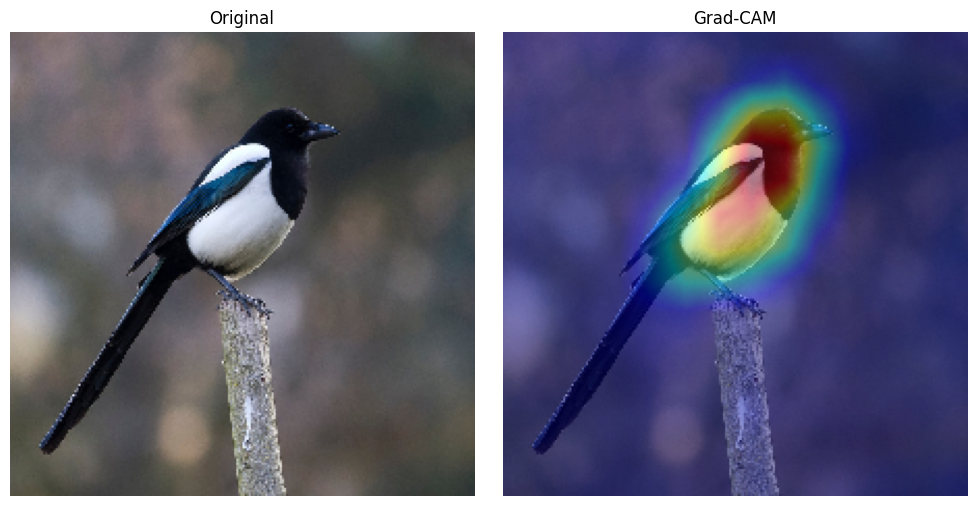

In [6]:
import cv2
import matplotlib.pyplot as plt

#load the original image and overlay the heatmap
img = cv2.imread(IMAGE_PATH)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#superimpose the heatmap on original image
superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

#show the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

It appears that the network is recognizing the magpie mainly from its body features. The tail gives little contribution. The background, too, is ignored.

# Conclusions

This technique can be used in two ways:

- if you already know what the network should look for (e.g. a magpie) you can check if the network is doing a good job or it is taking unwanted hints (e.g. recognizing a penguin from the snowy background and not the actual penguin)
- if you don't know what the network should notice (in our example: if you don't know what a magpie is) you can use the network to investigate the data